# Exploring PPO RL using multiple workers with Ray Rllib

In [1]:
import os
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
from pprint import pprint
from ray import air, tune
import numpy as np
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import register_env

# sixg_radio_mgmt
from sixg_radio_mgmt import (
    CommunicationEnv,
    Association,
    UEs,
    Channel,
    Mobility,
    Traffic,
    Agent,
)
from typing import Optional, Tuple, Union

## Radio resource scheduler simulator 

We utilize the radio scheduler simulator [sixg_radio_mgmt](https://github.com/lasseufpa/sixg_radio_mgmt) to simulate a scenario with 5 UEs. The dynamics of the communication environment are defined in the following classes:
- SimpleAssociation: Defines which UE is associated to each base station and slice. In our scenario here, all the five UEs are associated to the unique base station available in the scenario.
- SimpleChannel: Calculates the spectral efficiency values for each combination of UEs x RBs.
- SimpleMobility: The channels are fixed and does not consider the Mobility in the calculation. So, here, the mobility is just ignored.
- SimpleTraffic: Defines the throughput traffic requested by each UE.

In [2]:
class SimpleAssociation(Association):
    def __init__(
        self,
        ues: UEs,
        max_number_ues: int,
        max_number_basestations: int,
        max_number_slices: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            ues,
            max_number_ues,
            max_number_basestations,
            max_number_slices,
            rng,
            root_path,
            scenario_name,
        )
        self.basestation_ue_assoc = np.ones((1, max_number_ues), dtype=int)
        self.basestation_slice_assoc = np.ones((1, max_number_slices), dtype=int)
        self.slice_ue_assoc = np.ones((1, max_number_ues), dtype=int)

    def step(
        self,
        basestation_ue_assoc: np.ndarray,
        basestation_slice_assoc: np.ndarray,
        slice_ue_assoc: np.ndarray,
        slice_req: Optional[dict],
        step_number: int,
        episode_number: int,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Optional[dict]]:
        return (
            basestation_ue_assoc,
            basestation_slice_assoc,
            slice_ue_assoc,
            slice_req,
        )

In [3]:
class SimpleChannel(Channel):
    def __init__(
        self,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            max_number_ues,
            max_number_basestations,
            num_available_rbs,
            rng,
            root_path,
            scenario_name,
        )
        self.fixed_spec_eff = 5 * np.ones(
            (max_number_basestations, max_number_ues, num_available_rbs[0])
        )
        self.fixed_spec_eff[0, 0:3, :] = 20  # First 3 UEs have a higher throughput

    def step(
        self,
        step_number: int,
        episode_number: int,
        mobilities: np.ndarray,
        sched_decision: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        return self.fixed_spec_eff

In [4]:
class SimpleMobility(Mobility):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)

    def step(self, step_number: int, episode_number: int) -> np.ndarray:
        return np.ones((self.max_number_ues, 2))

In [5]:
class SimpleTraffic(Traffic):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)
        self.traffics_pattern = {
            "embb": {
                "num_ues": 3,
                "ue_throughput": 100,
            },
            "urllc": {
                "num_ues": 2,
                "ue_throughput": 10,
            },
        }

    def step(
        self,
        slice_ue_assoc: np.ndarray,
        slice_req: dict,
        step_number: int,
        episode_number: int,
    ) -> np.ndarray:
        traffic_per_ue = np.zeros(self.max_number_ues)

        # eMBB
        traffic_per_ue[0:3] = (
            self.traffics_pattern["embb"]["ue_throughput"] * 1e6
        )  # Mbps
        # URLLC
        traffic_per_ue[3:] = (
            self.traffics_pattern["urllc"]["ue_throughput"] * 1e6
        )  # Mbps

        return traffic_per_ue

## Defining scenario characteristics

In [6]:
seed = 10
number_ues = 5
number_basestations = 1
number_slices = 1
rbs_available = np.array([100])

steps_per_episode = 1000
training_episodes = 80
training_epochs = 1
testing_episodes = 20

The agent RL simple distributes the RBs among UEs considering an action space with one output per UE (A vector with 5 elements) with a value between -1 and 1. These values are converted to the number of RBs per UE in the `action_format()` function.

The observation space contains the normalized spectral efficiency and buffer occupancies for each UE, totaling an observation space with 10 variables (5 UEs x 2). The function `obs_space_format` is responsible for creating the observation space.

The function `calculate_reward` is responsible for calculate the reward that considers the average throughput sent by all the UEs in the system. Therefore, the goal of the RL agent is to maximize the total throughput.

The environment observation and action space are defined in the functions `get_action_space()` and `get_obs_space()`.  

In [7]:
class RLSimple(Agent):
    def __init__(
        self,
        env: CommunicationEnv,
        max_number_ues: int,
        max_number_slices: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        hyperparameters: dict = {},
        seed: int = np.random.randint(1000),
    ) -> None:
        super().__init__(
            env,
            max_number_ues,
            max_number_slices,
            max_number_basestations,
            num_available_rbs,
            seed,
        )
        self.agent_name = "ray_ppo"
        self.current_obs = None

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        return np.array([])

    def obs_space_format(self, obs_space: dict) -> Union[np.ndarray, dict]:
        # Function that create the observations
        self.current_obs = obs_space
        formatted_obs_space = np.array([])
        hist_labels = [
            "buffer_occupancies",
            "spectral_efficiencies",
        ]
        for hist_label in hist_labels:
            if hist_label == "spectral_efficiencies":
                spectral_eff_ues = (
                    np.mean(obs_space[hist_label][0], axis=1) / 20
                )  # Normalizing by 20
                formatted_obs_space = np.append(
                    formatted_obs_space,
                    spectral_eff_ues,
                    axis=0,
                )
            else:
                formatted_obs_space = np.append(
                    formatted_obs_space, obs_space[hist_label], axis=0
                )
        return formatted_obs_space

    def calculate_reward(self, obs_space: dict) -> Union[float, dict]:
        reward = (
            np.sum(obs_space["pkt_effective_thr"], dtype=float) * 65536 / 1e6
        ) / 1000  # Achieved throughput in Mbps divided by 1000 for normalization
        return reward

    def action_format(
        self,
        action: Union[np.ndarray, dict],
    ) -> np.ndarray:
        # Function that generate the actions
        curr_action = deepcopy(action)
        assert isinstance(curr_action, np.ndarray), "Action must be a numpy array"
        assert isinstance(
            self.current_obs, dict
        ), "Observation space must be a dictionary"
        sched_decision = np.array(
            [
                np.zeros((self.max_number_ues, self.num_available_rbs[basestation]))
                for basestation in np.arange(self.max_number_basestations)
            ]
        )
        if np.sum(curr_action + 1) == 0:
            curr_action = np.ones_like(curr_action)
        rbs_per_ue = np.floor(
            self.num_available_rbs[0] * (curr_action + 1) / np.sum(curr_action + 1)
        )
        assert not np.isnan(rbs_per_ue).any(), "NaN values in action"
        while np.sum(rbs_per_ue) != self.num_available_rbs[0]:
            rbs_per_ue[0] += 1

        sched_decision = self.distribute_rbs_ues(
            rbs_per_ue,
            sched_decision,
            np.arange(self.max_number_ues),
            self.num_available_rbs,
            0,
        )

        assert (
            np.sum(sched_decision) == self.num_available_rbs[0]
        ), "Allocated RBs are different from available RBs"

        return sched_decision

    def get_action_space(
        self,
    ) -> gym.spaces.Box:
        return gym.spaces.Box(
            low=-1, high=1, shape=(self.max_number_ues,), dtype=np.float64
        )

    def get_obs_space(
        self,
    ) -> gym.spaces.Box:
        return gym.spaces.Box(
            low=0,
            high=np.inf,
            shape=(2 * self.max_number_ues,),
            dtype=np.float64,
        )

    def distribute_rbs_ues(
        self,
        rbs_per_ue: np.ndarray,
        allocation_rbs: np.ndarray,
        slice_ues: np.ndarray,
        rbs_per_slice: np.ndarray,
        slice_idx: int,
    ) -> np.ndarray:
        rb_idx = np.sum(rbs_per_slice[:slice_idx], dtype=int)
        for idx, ue_idx in enumerate(slice_ues):
            allocation_rbs[0, ue_idx, rb_idx : rb_idx + rbs_per_ue[idx].astype(int)] = 1
            rb_idx += rbs_per_ue[idx].astype(int)

        return allocation_rbs

When using a custom environment in Ray RLlib, a function that returns the environment needs to be created to register the environment using Ray API:

In [8]:
def env_creator(env_config, training=True):
    comm_env = CommunicationEnv(
        ChannelClass=SimpleChannel,
        TrafficClass=SimpleTraffic,
        MobilityClass=SimpleMobility,
        AssociationClass=SimpleAssociation,
        config_file="rrs_simple",
        simu_name="rrs_simple",
        agent_name="ray_ppo",
    )
    rl_api = RLSimple(
        comm_env,
        number_ues,
        number_slices,
        number_basestations,
        rbs_available,
    )
    comm_env.set_agent_functions(
        obs_space_format=rl_api.obs_space_format,
        action_format=rl_api.action_format,
        calculate_reward=rl_api.calculate_reward,
        obs_space=rl_api.get_obs_space(),
        action_space=rl_api.get_action_space(),
    )
    comm_env.max_number_episodes = 80 if training else 100

    return comm_env


register_env("comm_env", lambda config: env_creator(config))

## Creating and training the RL agent

In [9]:
config = (
    PPOConfig()
    .environment("comm_env")
    .env_runners(num_env_runners=1)
    .learners(num_learners=1)
    .training(
        lr=0.0003,
        train_batch_size=2048,
        sgd_minibatch_size=64,
        num_sgd_iter=10,
        gamma=0.99,
        lambda_=0.95,
        model={
            "fcnet_hiddens": [64, 64],
            "fcnet_activation": "relu",
        },
        clip_param=0.2,
        entropy_coeff=0.01,
        vf_loss_coeff=0.5,
        grad_clip=0.5,
        vf_clip_param=np.inf,
        use_gae=True,
        kl_coeff=0,
        use_kl_loss=False,
        kl_target=0,
    )
)
stop = {
    "timesteps_total": 1000 * training_episodes * training_epochs,
}
checkpoint_frequency = 0
store_results_path = str(Path("./ray_results/").resolve()) + "/nb_3/"
agent_name = "ray_ppo"

tuner = tune.Tuner(
    "PPO",
    param_space=config.to_dict(),
    run_config=air.RunConfig(
        storage_path=store_results_path,
        name=agent_name,
        stop=stop,
        verbose=2,
        checkpoint_config=air.CheckpointConfig(
            checkpoint_frequency=checkpoint_frequency,
            checkpoint_at_end=True,
        ),
    ),
)
results = tuner.fit()
print(results)

2024-11-25 01:43:40,019	INFO worker.py:1783 -- Started a local Ray instance.
2024-11-25 01:43:40,650	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-11-25 01:43:40,652	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, act

(PPO pid=207945) Install gputil for GPU system monitoring.
(PPO pid=207945) 2024-11-25 01:43:53,701	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Trial name,agent_timesteps_total,counters,custom_metrics,episode_media,info,num_agent_steps_sampled,num_agent_steps_sampled_lifetime,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_lifetime,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_healthy_workers,num_in_flight_async_sample_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,timers
PPO_comm_env_b2841_00000,81920,"{'num_env_steps_sampled': 81920, 'num_env_steps_trained': 81920, 'num_agent_steps_sampled': 81920, 'num_agent_steps_trained': 81920}",{},{},"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float64(0.47442390345968305), 'cur_kl_coeff': np.float64(0.0), 'cur_lr': np.float64(0.0003), 'total_loss': np.float64(1.8658713206648827), 'policy_loss': np.float64(-0.0016591735882684588), 'vf_loss': np.float64(3.8844407909890832), 'vf_explained_var': np.float64(0.08685452081263065), 'kl': np.float64(0.0), 'entropy': np.float64(7.4689907565712925), 'entropy_coeff': np.float64(0.009999999999999998)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(64.0), 'num_grad_updates_lifetime': np.float64(12640.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(159.5)}}, 'num_env_steps_sampled': 81920, 'num_env_steps_trained': 81920, 'num_agent_steps_sampled': 81920, 'num_agent_steps_trained': 81920}",81920,81920,81920,81920,81920,2048,434.843,81920,2048,434.843,1,0,0,2048,"{'cpu_util_percent': np.float64(6.8), 'ram_util_percent': np.float64(23.016666666666666)}","{'training_iteration_time_ms': 4618.184, 'restore_workers_time_ms': 0.017, 'training_step_time_ms': 4618.133, 'sample_time_ms': 3635.958, 'load_time_ms': 0.294, 'load_throughput': 6965000.075, 'learn_time_ms': 978.663, 'learn_throughput': 2092.651, 'synch_weights_time_ms': 2.916}"


2024-11-25 01:46:56,218	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lasse/ray_minicourse/lesson_1/ray_results/nb_3/ray_ppo' in 0.0123s.
(PPO pid=207945) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/lasse/ray_minicourse/lesson_1/ray_results/nb_3/ray_ppo/PPO_comm_env_b2841_00000_0_2024-11-25_01-43-40/checkpoint_000000)
2024-11-25 01:46:56,292	INFO tune.py:1041 -- Total run time: 195.64 seconds (195.51 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float64(0.47442390345968305), 'cur_kl_coeff': np.float64(0.0), 'cur_lr': np.float64(0.0003), 'total_loss': np.float64(1.8658713206648827), 'policy_loss': np.float64(-0.0016591735882684588), 'vf_loss': np.float64(3.8844407909890832), 'vf_explained_var': np.float64(0.08685452081263065), 'kl': np.float64(0.0), 'entropy': np.float64(7.4689907565712925), 'entropy_coeff': np.float64(0.009999999999999998)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(64.0), 'num_grad_updates_lifetime': np.float64(12640.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(159.5)}}, 'num_env_steps_sampled': 81920, 'num_env_steps_trained': 81920, 'num_agent_steps_sampled': 81920, 'num_agent_steps_trained': 81920}, 'env_runners': {'episode_reward_max': np.float64(217.98099353599866), 'episod

## Selecting the best checkpoint from training

In [10]:
analysis = tune.ExperimentAnalysis(store_results_path + agent_name)
assert analysis.trials is not None, "Analysis trial is None"
checkpoint = analysis.get_best_checkpoint(
    trial=analysis.trials[0],
    metric="env_runners/episode_reward_mean",
    mode="max",
)
tuner_agent = Algorithm.from_checkpoint(checkpoint)

2024-11-25 01:46:56,352	WARNING deprecation.py:50 -- DeprecationWarning: `_enable_new_api_stack` has been deprecated. Use `AlgorithmConfig._enable_new_api_stack` instead. This will raise an error in the future!
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:557: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tun

## Testing the RL agent

In [11]:
comm_env = env_creator({}, training=False)
obs, _ = comm_env.reset(
    seed=seed, options={"initial_episode": training_episodes}
)  # Initial observation
for episode in tqdm(range(testing_episodes * 1000)):
    action = tuner_agent.compute_single_action(  # Here we compute the action using the trained agent
        obs,
        explore=False,
    )
    assert isinstance(action, np.ndarray), "Action must be a numpy array"
    obs, reward, terminated, truncated, info = comm_env.step(
        action
    )  # Applying the action in the environment
    if terminated:
        comm_env.reset()

100%|██████████| 20000/20000 [00:28<00:00, 694.11it/s]


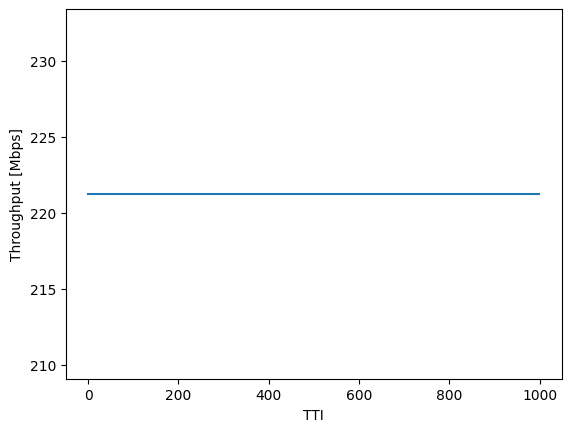

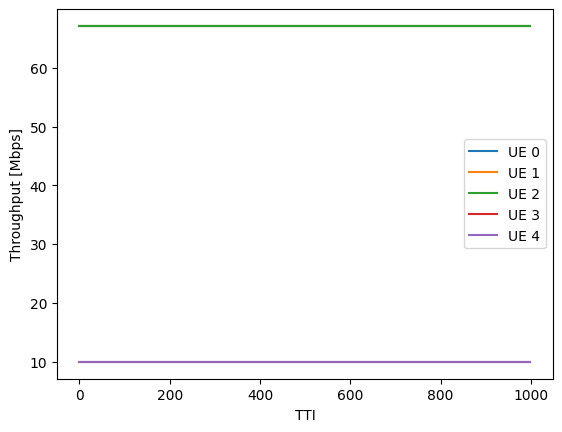

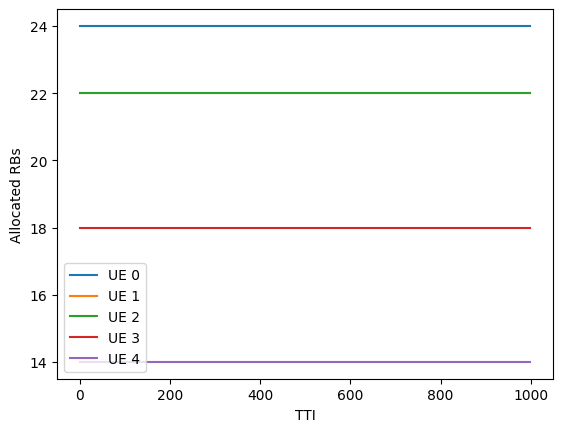

Total throughput achieved: 221249.53600000008


In [12]:
hist_ep_80 = np.load("hist/rrs_simple/ray_ppo/ep_80.npz")
pkt_size = 65536  # Default packet size in bits
effective_throughput = hist_ep_80["pkt_effective_thr"] * pkt_size / 1e6
pkt_incoming = hist_ep_80["pkt_incoming"] * pkt_size / 1e6
total_throughput = np.sum(effective_throughput, axis=1)
rbs_per_ue = np.squeeze(hist_ep_80["sched_decision"]).sum(axis=2)

# Total achieved throughput
plt.figure()
plt.plot(total_throughput, label="Total throughput")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.show()

# Achieved throughput per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(effective_throughput[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.legend()
plt.show()

# RBs per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(rbs_per_ue[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Allocated RBs")
plt.legend()
plt.show()
print(f"Total throughput achieved: {np.sum(total_throughput)}")